# Uncertainty in Profit Scoring (Bayesian Deep Learning)

Djordje Dotlic<br>
Batuhan Ipekci<br>
Julia Dullin<br>

## Contents

1. [Introduction](#intro)
2. [Literature Review](#lit_rev)
3. [Theory](#theory)
    [Bayesian Inference](#bayesian)
    [Variational Inference](#var_inf)
4. [Data Exploration](#explore)
    1. [Lending Club Loan Data](#lend)
    2. [Splitting the Data Set](#split)
5. [Implementation](#implementation)
    1. [Pre-Processing](#pre)
    2. [Model](#model)
    3. [Prediction](#pred)



## Introduction 

<a id="intro"></a>
The problem of credit scoring is a very standard one in Machine Learning literature and applications. Predicting whether or not a loan applicant will go default is one of the typical examples of classification problem, and usually serves as a good ground for application and comparison of various machine learning techniques- which, over the years, became very precise in making a binary prediction. However, the credit scoring problem can be thought about as a regression problem as well. What is to be predicted here, instead of failure probability as in the classification case, is the profit rate- earnings from a loan for the lender expressed as a percentage of the amount of money loaned. The motivation for the second approach is that, even if a borrower fails to pay off the entire loan, the lender can still earn the money, and still have an interest to invest in this particular opportunity rather than some other (if profit rate is higher than in some other investment opportunity with the same risk level). The Lending Club dataset of loans from 2007-2015 (data will be properly introduced in a separate section) offers a good example of such a situation. Since it is offering a peer-to-peer landing, we can think about each loan application as an individual investment opportunity (unlike in case of bak loans where decisions are driven by some more general risk management strategies). Hence, we can treat credit scoring (and making a subsequent decision on loan granting or rejecting) as a regression problem where the information applicants are providing are used as predictors of the profit rate. The goal is to avoid "bad" loans, or, in other words, the loans that make lenders lose money.

If we are treating a loan as other securities, such as bonds, commodities, currencies, and such, we might like to assess it in a similar way regarding its risk. For tradable assets, we can follow daily price changes and formulate the expected return, volatility, skewness and kurtosis of returns distribution, which is further used for making a portfolio decision. In the case of loans, we don't have such high-frequency data. Usually, there is some credit history, but few data points cannot lead to any reasonable assumptions about future movements. Hence, one solution would be to just use the predicted expected return or to use a classification approach.

One way around this caveat is the application of Bayesian Method in the estimation of a model. Unlike in the more traditional, deterministic, approach, the result of the prediction isn't a point estimate. Instead, by applying different methods in the estimation (Monte Carlo Simulations, among others), the outcome of prediction is (an approximation of) distribution of probabilities. Generally, these methods have been known for a very long time, but due to very high costs of computation were usually overlooked. However, with recent advances in statistical theory as well as with an increase in computational power of computers, different methods were invented that overcome the aforementioned hardships yet achieve their goal. As usual, there is no free lunch, and these new methods have their own weaknesses which will be discussed later in this article. In any case, the authors made use of these enhancements to predict distributions of profit rates for the loan applications. With this result, it was easy to calculate shape measures of distribution (mean, median, mode, variance, skewness, kurtosis).

With these measures, we can finally compare loans with other investment opportunities. One of the most traditional methods used to evaluate an investment opportunity is the Sharpe Ratio. Sharpe Ratio, introduced by William F. Sharpe in 1966 under the name "reward-to-variability" (Sharpe, W.E. 1966), penalizes the excess expected return over risk-free rate by the standard deviation of the returns. Hence, we could use the predicted mean profit rate of a loan application and divide it by the standard deviation of the predicted distribution. Hence, from two loans that bring us the same profit rate, but under different risk (standard deviations), we would prefer the one with a lower standard deviation. In other words, a loan that has a higher Sharpe Ratio. It should be, however, noted that Sharpe Ratio assumes distributional normality of returns. This is a standard assumption in finance which means that different stocks, for example, have normally distributed returns and that they differ in the mean and variance only, while kurtosis and skewness are the same (normal distribution has a skewness of zero- it is a symmetrical distribution, and kurtosis, the fatness of tails, of 3). Indeed, Jarque-Bera test is a way to statistically test for normal distribution of a random variable and it is constructed from skewness and kurtosis estimates. In our case, we find an assumption of normally distributed returns unnecessarily strong. We would expect that some loan applicants have a higher probability of default (hence a fatter tail of the probability distribution) and distributions not to be symmetrical. Hence, mean and variance do not sufficiently describe the distribution, and we need a measure that includes skewness and kurtosis. Pezier and White (1996) proposes an adjustment of Sharpe Ratio that penalizes Sharpe Ratio for a negative skewness and excess kurtosis. This sounds applicable in our case, as we expect individual distributions to have a longer left than a right, tail. The Adjusted Sharpe Ratio will be explained in more detail later in this article.

The structure of this article is as follows:
First, we will explain the theory behind Bayesian neural networks, including different approaches to it. Then we'll move towards application by introducing the lending club dataset. Finally, we present a novel method to evaluate the results and compare the models. During the blog post, relevant chunks of code will be included and briefly explained.

## Literature Review
<a id="lit_rev"></a>


Despite the fact that the most accurate default prediction models aren't the most profitable (Lessmann et al (2015)), the literature on the profit rate prediction (i.e. Profit Scoring) is relatively scarcer than in the previous case. One of the first papers that implemented this approach was Andreeva et al (2007) who defined a model that shows improvement in the profit by application of revenue predicting models with a survival probability of default compared to "static probability" in case of the store card for white durable goods. Some of the papers that deal with Profit Scoring are Bayraci (2017) who uses multiple machine learning techniques to predict the default rate, but on top of that utilizes Expected Maximum Profit framework introduced by Verbraken et al (2014) to find the profit-maximizing cutoff and evaluate the models. Bastani et al. (2018) propose a two-step scoring approach based on both default probability prediction and profit scoring in the case of the peer-to-peer lending market. They argue that the combination of both methods is necessary as the default probability ignores profit and profit based one ignores class imbalance. Cinca and Nieto (2016) propose a profit scoring for peer-to-peer lending and show that it is possible to obtain a higher profit by using profit based measures than more standard default probabilities one. They use the Internal Rate of Return as a profitability measure and provide a decision support system for selecting the most profitable loan applicants. Finlay (2008) proposes a continuous model of customer worth for lender. By using logistic and linear regression he shows that these measures outperform the classification based ones when loan applications are ranked by their worth to lenders. Barrios et al (2014) introduced absolute and relative profit measures for consumer credits and showed that their novel scorecards outperform traditional ones regarding the portfolio returns.

Some research in the context of Bayesian models in finance area was done under Shah and Zhang (2014) where they predicted Bitcoin price with Bayesian regression and defined a successful trading strategy that almost doubles the returns compared to the benchmark. Pires and Marwala (2007) used Automatic Relevance Determination and Hybrid Monte Carlo method for Bayesian Neural Networks in order to predict the call option price with stock volatility, strike price and time to maturity as independent variables. Moreira et al. (2017) proposed quantum-like inference of Bayesian network in comparison to the classical one in order to deal with the issue of missing data in the context of bank loans and shows critical improvement in terms of error under quantum-like inference model. 

However, to our best knowledge, no study implemented a Bayesian Deep Learning framework to this matter or used a similar measurement to make a loan decision.

## Theory
<a id="theory"></a>
### Bayesian Inference
<a id="bayesian"></a>
Bayesian models are beautiful. They have their own version of Occram's Razor which tells us they do not overfit as easy as usual neural networks with deterministic weights (MacKay 2004). They are also robust to outliers (Ghahramani 2011). It makes sense to use Bayesian inference in situations where it is very expensive to obtain a large amount of data, such as DNA-sequencing, or where we need to apply interpolations quite frequently such as in geostatistics or astrophysics.
Under the perspective of the Bayesian inference, each observation is an opportunity to criticize/update our beliefs about a given a (deep learning) model. Using the Bayes' rule below, we can figure out how the degree of belief in a model ( **the posterior function $P(\omega|X)$**) is related to the likelihood of data (** the likelihood function $P(X|\omega)$**) , our knowledge about the data ( **the prior $P(\omega)$**) and the evidence (**the marginal likelihood $P(X)$**):

\begin{equation}
p(\omega | X) = \frac{p(X, \omega)}{P(X)} \implies p(\omega | X) = \frac{p(X|\omega)p(\omega)}{p(X)}
\end{equation}

Having defined the posterior as above, the prediction on new observations *$x_{new}$* is made through model update/criticism on the **posterior predictive distribution**. Note that we $p(x_{new}|X)$ parametrized with $\omega$ which represents the parameters of any models we would like to use:

\begin{equation}
p(x_{new}|X) = \int p(x_{new}| \omega)p(\omega | X) d\omega
\end{equation}

So far, everything seems fine:  As oppose to deterministic neural networks which maximize **the likelihood function** $P(X|\omega)$ and obtain only point estimates, we can calculate the **posterior predictive distribution** $P(x_{new}|X) $ and get a distribution of estimations for each observation. Except that it is very difficult in nonlinear models to calculate the posterior directly (Murphy 2012). The reason is that the integral above is intractable because the posterior $P(\omega|X)$ is intractable. And posterior is intractable because the evidence $P(X)$ is intractable. To see this argument more clearly, let's rewrite the evidence $P(X)$ by using the law of total probability as parametrised by our model's parameters $\omega$:

\begin{equation}
p(X) = \int p(X,\omega)d\omega
\end{equation}

As we see, the evidence, i.e. the denominator of the posterior function, represents a high-dimensional integral that lacks a general analytic solution. Therefore, calculating the posterior usually means **approximating** it. There is a whole literature out there on how to approximate the posterior as we also discussed in the previous section. After we are done with approximating the posterior, our neural network in a regression problem will look like this:

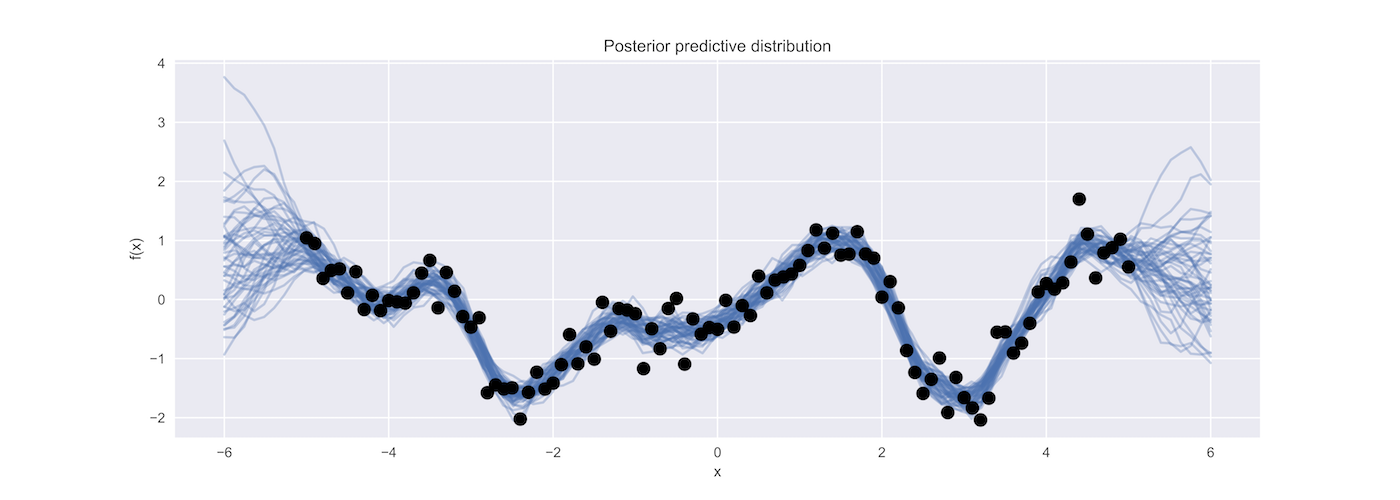

Observe that for each point in the graph, we have a number of fits. The variance of fitted functions are the highest at the region where we don't have data and it is the lowest where we have a concentration of data. We can also interpret it during prediction in a way that we have the
highest aleatoric uncertainty at the region where we have the least clue about our data.

We explained what the posterior is. But what about the prior $p(\omega)$, our domain knowledge of the data? Does our choice of the prior matter? It matters. If we use conjugate priors, we will actually have closed-form solutions for estimating the posterior. Conjugate priors simplify the computation. And in that case it is suggested to choose an uninformative prior which does not depend on data (Murphy 2012). Your choice of the distributional family of the prior can affect the predictions you make. However, in the neural network setting, we usually do not have models with nice conjugate priors. Therefore, it increases complexity of applying variational inference. Successful applications require fine-tuning of the distributional parameters of the prior.In this blog post, we only consider Gaussian priors with lengthscale (function frequency), which is a suitable choice for regression problems.

### Variational Inference
<a id="var_inf"></a>
The posterior is intractable. We need to approximate it. The most popular two approaches in approximating the posterior are sampling-based methods like Markov chain Monte Carlo (MCMC) and variational inference (VI). Sampling-based methods usually take so much computational resources that they are almost impractical to use in deep learning. We need a shortcut. VI is such a shortcut. The idea is to find the closest function $q(\omega)$ to the posterior $p(\omega | x)$. In order to find it, we minimize the Kullback-Leibler divergence (KL divergence) of $q(\omega)$ from $p(\omega | x)$. In other words, we minimize $KL( q(\omega)  ||  p(\omega | x) )$. To do so, we assume that $\omega$ is parametrized by some latent variable $\theta$ (here, the latent of the latent, which we also call 'variational parameters'), and apply minimization with respect to $\theta$.

\begin{equation}
\underset{\theta}{\operatorname{min}}KL(q(\omega ; \theta) || p(\omega | x))
\end{equation}

Note that KL divergence is non-symmetric, meaning that reversing the arguments will lead us to a totally different method. Also note that what we are doing here is optimizing functions to find the best functional  representation of the posterior $p(\omega|x)$. This optimization belongs to the field of 'calculus of variations' (Bishop 2006). To think about this optimization problem, we can rewrite below what KL divergence actually is:

\begin{equation}
\underset{\theta}{\operatorname{min}}KL(q(\omega ; \theta) || p(\omega | x)) 
\iff  
\underset{\theta}{\operatorname{min}} \mathop{\mathbb{E}}_{q(\omega | \theta)}[ logq(\omega; \theta) - log p(\omega | x)]
\end{equation}

One question immediately appears: How do we minimize the distance to the posterior if we don't even know what the posterior is? It is a nontrivial question. We can have a clue about the posterior only if we have data. Let's play with the KL divergence if we can recover the evidence $p(x)$ any where around. We will rewrite the posterior by using the Bayes's rule:

\begin{equation}
\mathop{\mathbb{E}}[ logq(\omega; \theta) - log p(\omega | x)] = \mathop{\mathbb{E}}[ logq(\omega; \theta) - log \frac{p(x,\omega)}{p(x)}]
\end{equation}

Reorganizing the expectation above gives us the evidence lower bound $ELBO(\theta)$:

\begin{equation}
KL(q(\omega ; \theta)||p(\omega | x))= -\mathop{\mathbb{E}}[log p(x,\omega)-logq(\omega;\theta)]+\mathop{\mathbb{E}}logp(x)
\end{equation}

\begin{equation}
ELBO(\theta)=\mathop{\mathbb{E}}[logp(x,\omega)-logq(\omega;\theta)]
\end{equation}

As we see, $logp(x)$ does not depend on $\theta$. That means minimizing $KL(q(\omega ; \theta) || p(\omega | x))$ is the same thing as maximizing ELBO($\theta$) which we call the evidence lower bound. That means, it is something that makes sense to maximize. We can prove that ELBO($\theta$) is a lower bound to the evidence P(x) easily by using Jensen's Inequality. If you are interested, you can check out the full derivations in the documentation page of the python library Edward, http://edwardlib.org/tutorials/klqp.

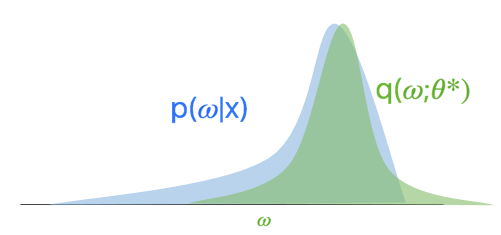

We have a graphical explanation above. We maximize the evidence lower bound as to attain the closest function to the posterior as we can. There are still some KL divergence of $q(\omega ; \theta)$ from the real posterior $p(\omega | x)$. We are not guaranteed to reduce this difference completely. It is the drawback of implementing this approach. We cannot make this KL-divergence zero in general and might not really attain the real posterior, regardless of how ambitious we are in optimization.

As you'll wonder, the ELBO($\theta$) is a non-convex optimization objective and there are many ways to minimize ELBO($\theta$). We can apply variants of stochastic gradient descent. 

### Monte Carlo Dropout
Scared by all those mathematical derivations of the variational inference? Good news to you: An interesting finding in deep learning research suggests that you can apply variational inference without even knowing all those derivations. And it is going to be much faster and applicable. Yarin Gal (2016) suggests that we are doing something very close to a type of variational inference each time we regularize our deterministic neural network with dropout technique. According to his PhD thesis, all we need is to apply dropout during both training and test time, as opposed to the usual application of dropout only during model training (Gal, 2016). Let's review what the usual dropout is:

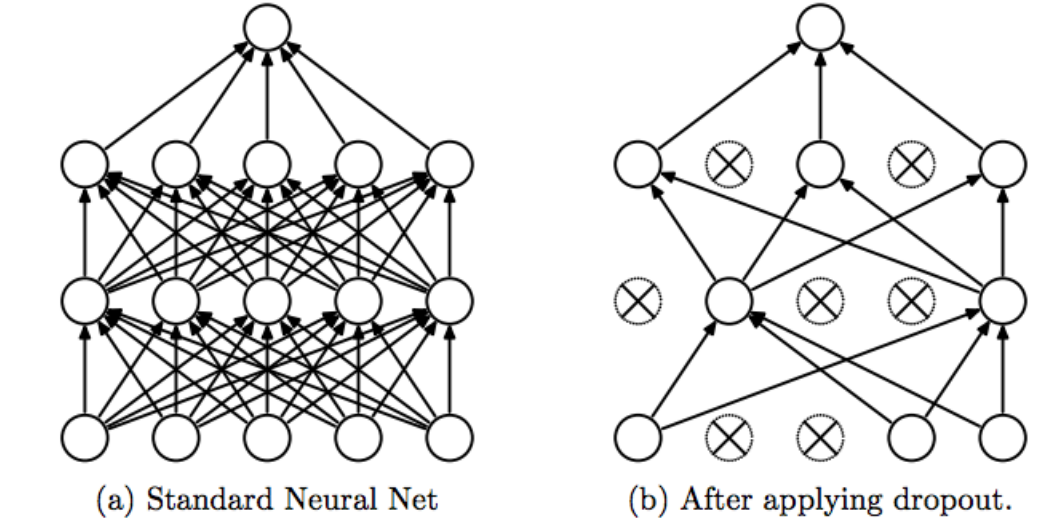

If we build a complicated neural network with lots of hidden layers and cells on a limited amount of training data, our model would probably memorize the data and does not generalize well. This phenomenon is called **overfitting**. Dropout is a regularizer to avoid overfitting by disabling some cells in hidden layers with some probability (Srivastava et. al. 2014). By doing this, dropout effectively samples from an exponential number of different networks in a tractable and feasible way. Dropout is computationally cheap and it can be applied in nearly any neural network architecture with ease. Wenn applying dropout, we basically do not change anything in our neural network in terms of optimization and model architecture. We only add a specific l2 weight regularisation term (which corresponds to choosing a prior) and dropout regularisation (which makes sampling from the posterior automatically) before each layer (input, hidden, output). Additionally, we need to apply dropout both in the training and test periods as opposed to its usual implementation. That's all.

Yarin Gal tied up several derivations of stochastic variational inference to those of the stochastic regularization techniques, including dropout. Encouraged by this finding, he suggests to use dropout during test time in order to obtain approximate samples from the posterior function $p(\omega | x)$. When we apply dropout during test time, we obtain different results each time we run the model. They are approximate samples from the posterior predictive distribution. Gal calculates unbiased estimators for the mean and the variance of the posterior predictive distribution as the following:

Consider $y=f^{\hat{\omega}}(x)$ as the output of the Bayesian NN, and t= 1,.., T are samples from the posterior predictive distribution

\begin{equation}
\mathop{\mathbb{\hat{E}}}(y)=\frac{1}{T}\sum_{t=1}^{T}f^{\hat{\omega_t}}(x)
\end{equation}

\begin{equation}
\mathop{\mathbb{\hat{E}}}(y^{T}y) = \tau^{-1}I + \frac{1}{T}\sum_{t=1}^{T}f^{\hat{\omega_t}}(x)^{T}f^{\hat{\omega_t}}(x) -  \mathop{\mathbb{\hat{E}}}(y)^{T} \mathop{\mathbb{\hat{E}}}(y)
\end{equation}

Note that $f^{\hat{\omega}}(x)$ is a row vector. The mean of our posterior predictive samples is an unbiased estimator of the mean of the approximate distribution $q(\omega)$. The sample variance plus a term $\tau^{-1}I$ is also an unbiased estimator of the variance of $q(\omega)$. That means, with only a small adjustment made to the sample variance, we get the Bayesian results very handy. The adjusting term $\tau$ equals to the following:

\begin{equation}
\tau = \frac{(1-p)l^{2}}{2N\lambda}
\end{equation}

N is the number of data points. $l$ is the prior lengthscale capturing our subjective belief over the prior's frequency. A short length-scale $l$ corresponds to high frequency prior, and a long length-scale corresponds to low frequency prior. $\lambda$ corresponds to the weight decay regularization term which we additionally use to regularize weight optimization. As a trick during application we will play the equation above, and leave the $\lambda$ alone:

\begin{equation}
\lambda = \frac{(1-p)l^{2}}{2N\tau}
\end{equation}

The best $p$, $\tau$ and $\lambda$ can be found by cross-validation. They are the only paramteres to optimize when using the MC dropout approach. It is a big relief considering the fact that sampling methods like MCMC and HMC usually require many parameters to optimize. After choosing $\lambda$, $p$ and $\tau$, all we need is to calculate the l2 weight-decay regularisation term $\lambda$ and apply this additional regularisation to our neural network model. Then we can calculate the statistical properties of our samples of posterior distribution in order to get new insights.

## Data Exploration
<a id="explore"></a>

For this tutorial, we aim to implement a Bayesian neural network using the MC Dropout technique to predict profit rates for the lending club loan data. Because a Bayesian neural network provides a distribution of probabilities, rather than a point estimate, we are able to use this distribution to then calculate measures including kurtosis, skewness, and variance. Later in this blog post, these measures will then be used to interpret the results.

### Lending Club Loan Data
<a id="lend"></a>
The lending club loan data set (accessible on kaggle.com: https://www.kaggle.com/wendykan/lending-club-loan-data) contains data for loans in the period of 2007 - 2015. It includes, among others, information about current payments, the loan status (current, late, fully paid etc.) and data about the borrower such as state, annual income and home ownership. The complete data set consists of approximately 890.000 rows and 74 columns.

Before we implement the Bayesian neural network, we will explore and clean the data. Because we are only interested in past loans, we have already created a new data set, for which we removed loans where the loan status is "current". We now have a data set with 285,600 rows and 74 columns.

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
loan = pd.read_csv("data/loans_Past.csv", low_memory=False)

In [4]:
print(loan.shape)
loan.head()

(285600, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first few rows of the data set show that some of the columns seem to have quite a lot of missing values.
In order to obtain a better overview, we start by creating a data set `loan_missing` which contains boolean values for missing data. We then sum those missing values by column and calculate the percentage. Lastly, we order the dataframe by the percentage of missing values, with the highest percentage on top.

In [18]:
loan_missing = loan.isna()
loan_missing_count = loan_missing.sum()

loan_missing_percentage = (loan_missing_count / len(loan)).round(4) * 100
loan_missing_sorted = loan_missing_percentage.sort_values(ascending=False)
loan_missing_sorted.head(20)

dti_joint                      99.98
verification_status_joint      99.98
annual_inc_joint               99.98
il_util                        97.50
mths_since_rcnt_il             97.19
max_bal_bc                     97.12
open_rv_24m                    97.12
open_rv_12m                    97.12
all_util                       97.12
total_bal_il                   97.12
open_il_24m                    97.12
open_il_12m                    97.12
open_il_6m                     97.12
open_acc_6m                    97.12
total_cu_tl                    97.12
inq_fi                         97.12
inq_last_12m                   97.12
next_pymnt_d                   88.58
mths_since_last_record         86.81
mths_since_last_major_derog    80.24
dtype: float64

The resulting table proves that a lot of columns are almost completely empty. For further data exploration, we set a threshold of 50% and remove each column above this threshold. We now have 52 columns left.

In [40]:
temp = [i for i in loan.count()<len(loan)*0.50]
loan.drop(loan.columns[temp],axis=1,inplace=True)
loan.shape

(285600, 53)

Since there is no profit column existing in our data set yet, we define a target variable `profit` containing the profit rate of each loan. Then we have a look at the distribution of profits in order to find out if there are any imbalances in our target variable. We classify the target values as positive / negative profit and count the occurences in each class.

In [41]:
loan["profit"] = loan.apply(lambda x: ((x['total_pymnt'] - x['loan_amnt'])/x['loan_amnt']), axis = 1)
loan["profit"] = loan["profit"].round(2)

target_class = pd.DataFrame(columns=["class"])
target_class["class"] = [1 if i > 0 else 0 for i in loan["profit"]]
target_class["class"].value_counts()

1    208985
0     76615
Name: class, dtype: int64

The profit classes show that there are far more instances of positive profit than negative profit, meaning that our data set is imbalanced. In order to avoid a biased prediction, we will need to balance the data later on in the tutorial.
Now, we will have a look at what variables have the highest positive and negative correlation with our target variable.

In [42]:
loan.head()
corr = loan.corr()["profit"].sort_values(ascending=False)
print('most positive correlations:\n', corr.head(10))

print('most negative correlations:\n', corr.tail(10))

most positive correlations:
 profit              1.000000
total_rec_prncp     0.551126
total_pymnt         0.515352
total_pymnt_inv     0.510558
last_pymnt_amnt     0.362307
total_rec_int       0.218768
tot_cur_bal         0.040476
annual_inc          0.020393
total_rev_hi_lim    0.004064
inq_last_6mths      0.000856
Name: profit, dtype: float64
most negative correlations:
 int_rate                  -0.100841
int_rate_dec              -0.100841
collection_recovery_fee   -0.137428
dti                       -0.146143
recoveries                -0.229157
id                        -0.481423
member_id                 -0.482082
out_prncp                 -0.543330
out_prncp_inv             -0.543338
policy_code                     NaN
Name: profit, dtype: float64


The columns `total_rec_prncp` (prinicpal received to date),`total_pymnt` (payments received to date for total amount funded) and`total_pymnt_inv` (payments received to date for portion of total amount funded by investors) have the highest positive correlation with our target column. The columns`out_prncp` (remaining outstanding principal for total amount funded) and `out_prncp_i` (remaining outstanding principal for portion of total amount funded by investors) have the highest negative correlation with the target column.

This certainly seems feasible for our past loans, but if we think about using the model for real world predictions, these variables may not be as significant.

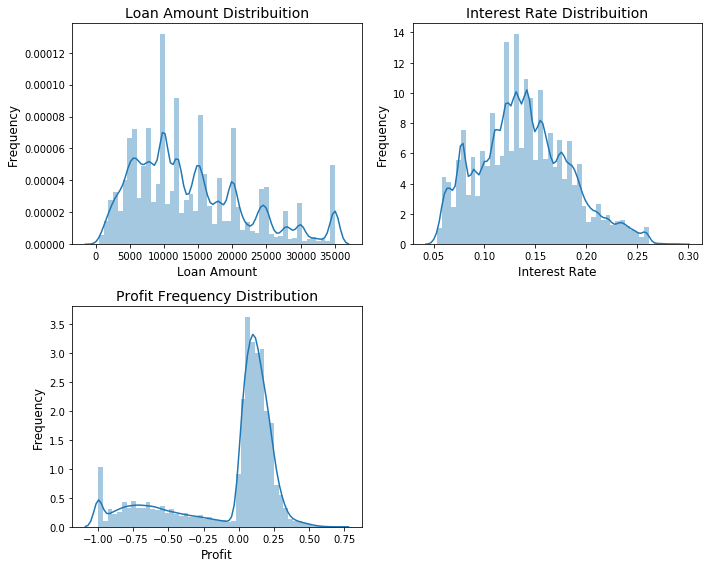

In [48]:
loan["int_rate_dec"] = loan.apply(lambda x: (x["int_rate"]/100), axis = 1)
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(221)
g = sns.distplot(loan["loan_amnt"], ax=ax1)
g.set_xlabel("Loan Amount", fontsize=12)
g.set_ylabel("Frequency", fontsize=12)
ax1.set_title("Loan Amount Distribution", fontsize=14)


ax2 = fig.add_subplot(222)
g1 = sns.distplot(loan['int_rate_dec'], ax=ax2)
g1.set_xlabel("Interest Rate", fontsize=12)
g1.set_ylabel("Frequency", fontsize=12)
ax2.set_title("Interest Rate Distribution", fontsize=14)


ax3 = fig.add_subplot(223)
g2 = sns.distplot(loan["profit"])
g2.set_xlabel("Profit", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
ax3.set_title("Profit Frequency Distribution", fontsize=14)

fig.tight_layout()

The above plots show the distributions of loan amount, interest rate and profit frequency. The majority of loans amount to 5.000 - 15.000$ each. Interest rates are mostly distributed between 0.10 - .20 \%. The distribution of profit rates shows that there are only a few loans in the negative range. The profit distribution spikes between 0.00 - 0.25 \%.

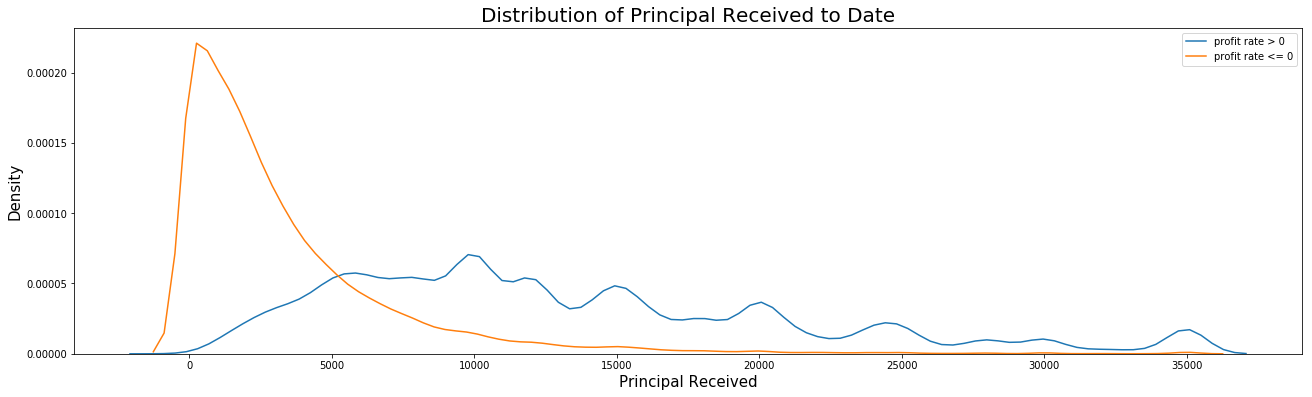

In [9]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(loan.loc[loan['profit'] > 0, 'total_rec_prncp'], label = 'profit rate > 0')
sns.kdeplot(loan.loc[loan['profit'] <= 0, 'total_rec_prncp'], label = 'profit rate <= 0');
plt.xlabel('Principal Received',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Principal Received to Date',fontsize=20);

The distribution of principal received to date shows that most instances with negative profits appear in the range of 0 - 10,000$, whereas instances with positive profits are more widely distributed. Next, we will see if there are any borrowers who have taken more than one loan to see if their member ID could be an indicator of the profit rate.

In [10]:
loan['member_id'].value_counts().head()

1415743     1
11967366    1
34691966    1
2708351     1
40483058    1
Name: member_id, dtype: int64

There are no members who have taken more than one loan. Consequently, the member id does not indicate whether the borrower is likely to pay back their loan. Hence, the column does not need to be considered for predictions.

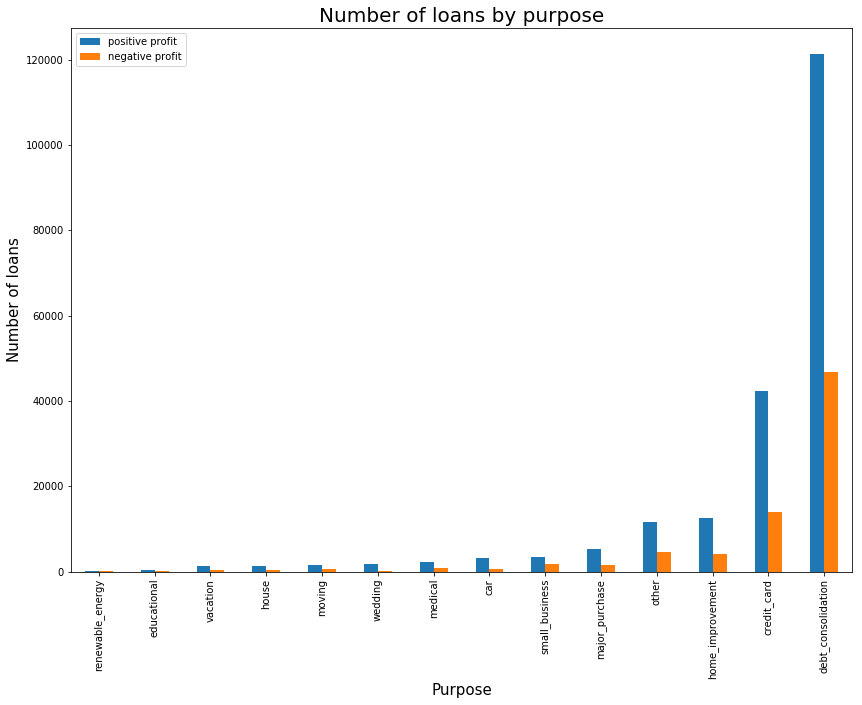

In [11]:
profit_by_purpose = pd.DataFrame(loan[loan['profit']>0].groupby('purpose')['profit'].count().sort_values())
profit_by_purpose["profit_neg"] = pd.DataFrame(loan[loan['profit']<=0].groupby('purpose')['profit'].count().sort_values())["profit"]

fig, ax = plt.subplots(figsize=(14, 10))
profit_by_purpose.plot(kind="bar", ax=ax)
plt.ylabel('Number of loans',fontsize=15)
plt.xlabel('Purpose',fontsize=15)
plt.title('Number of loans by purpose', fontsize=20);
L=plt.legend()
L.get_texts()[0].set_text('positive profit')
L.get_texts()[1].set_text('negative profit')

The barplot shows the number of loans issued per purpose category. Most loans are issued for debt consolidation and credit cards - these are also the categories with the highest amount of loans with negative profit. There is no category where the amount of loans with negative profits exceeds loans with positive profits. However, there certainly are categories where the share of negative profits is very small, such as house, car or wedding.

### Splitting the Data Set

<a id="split"></a>
In order to obtain comparable results, we split the loan data set into a test set with 40k rows, and five diffrent training sets with 60k, 100k, 150k, 200k and 240k rows. To do this, we use the `train_test_split()` function by `sklearn`. Furthermore, we add the profit rate directly into the data set as our target variable. We save each data set as a csv file for later use. 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

loan_past = pd.read_csv("data/loans_Past.csv", low_memory=False)
loan_past = loan_past.dropna(axis=1, how='any')

target = loan_past.apply(lambda x: ((x['total_pymnt'] - x['loan_amnt'])/x['loan_amnt']), axis = 1)

x_train_240k, x_test_40k, y_train_240k, y_test_40k = train_test_split(loan_past, target, test_size=40000, random_state=42)
x_train_200k, x_test_rm, y_train_200k, y_test_rm = train_test_split(x_train_240k, y_train_240k, test_size=40000, random_state=28)
x_train_150k, x_test_rm_2, y_train_150k, y_test_rm_2 = train_test_split(x_train_200k, y_train_200k, test_size=50000, random_state=3)
x_train_100k, x_test_rm_3, y_train_100k, y_test_rm_3 = train_test_split(x_train_150k, y_train_150k, test_size=50000, random_state=49)
x_train_60k, x_test_rm_4, y_train_60k, y_test_rm_4 = train_test_split(x_train_100k, y_train_100k, test_size=40000, random_state=12)

x_test_40k.to_csv("test_set_40k.csv", index=False)
x_train_240k.to_csv("train_set_240k.csv", index=False)
x_train_200k.to_csv("train_set_200k.csv", index=False)
x_train_150k.to_csv("train_set_150k.csv", index=False)
x_train_100k.to_csv("train_set_100k.csv", index=False)
x_train_60k.to_csv("train_set_60k.csv", index=False)

## Implementation

<a id="implementation"></a>
Now that we have an overview of the data and defined fixed data sets for testing and training, we will implement a Bayesian neural network using the MC Dropout technique to predict profit rates for the lending club data. The model will be based on `keras`, a deep learning library for Python. For pre-processing the data we will use `klearn` as well as `imblearn`.

In [ ]:
import pandas as pd
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from keras import Model as mcModel
from keras import Input as mcInput
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

We start by reading in our data sets. We have prepared the data by splitting the data set into a test data set with 40k rows and multiple training data sets with 60k, 100k, 150k, 200k and 240k rows, respectively. This way, we ensure that the same data is used on each model and the results are comparable. For splitting the data, we used the function `train_test_split()` by sklearn.

For easy access, we create a list of the file names of the data sets. Then we read each file using a for loop, and save the data in a dictionary using the file name as a key.

In [ ]:
data_sets = ["test_set_40k", "train_set_60k", "train_set_100k", 
             "train_set_150k", "train_set_200k", "train_set_240k"]

data = {} 
for item in data_sets:
    file = pd.read_csv("data/" + item + ".csv")
    data[item] = file

### Pre-Processing
<a id="pre"></a>
First, we implement a function to pre-process the data according to our findings in the data exploration section. The first step is to drop any missing data. As mentioned above, our data set is imbalanced. A solution to balancing data sets is to use the SMOTE (Synthetic Minority Over-sampling Technique) function provided by `imblearn`. SMOTE generates synthetic data points to oversample the minority class. However, SMOTE usually cannot be used for regression problems. For this reason, we have to temporarily change our target variable to a classification problem. We classify our profit rates into negative profits and positive profits, and apply the SMOTE function on those classes. We use profit rate as an additional feature instead. After oversampling, we simply drop the profit classes and re-define the profit rate as the target variable. Since SMOTE is only applied to training data, we included a boolean parameter to switch SMOTE on and off. In the case of test data, we simply define our features and target variable.

Lastly, we scale the data using `StandardScaler()` provided by `sklearn`.

In [ ]:
def preprocess(train_data, smote = True):
    train_data = train_data.dropna()
    
    if smote:
        features = train_data[['int_rate','loan_amnt', 'purpose', 'dti','term','grade', 'profit_rate']]
        features = pd.get_dummies(features)
        target = [1 if i > 0 else 0 for i in features['profit_rate']]
        
        sm = SMOTE(random_state = 43, ratio = 'minority')
        x_feat_1, x_targ_1 = sm.fit_sample(features, target)
        
        x_features = pd.DataFrame(x_feat_1)
        x_features.columns = features.columns
        x_target = x_features[["profit_rate"]]
        x_features = x_features.drop("profit_rate", axis=1)
        
    else:
        x_features = train_data[['int_rate','loan_amnt', 'purpose', 'dti','term','grade']]
        x_features = pd.get_dummies(x_features)
        x_target = train_data[['profit_rate']]

    scaler_features = preprocessing.StandardScaler().fit(x_features)
    x_features = scaler_features.transform(x_features)
  
    scaler_target = preprocessing.StandardScaler().fit(x_target)
    x_target = scaler_target.transform(x_target)
  
    return x_features, x_target

### Model

<a id="model"></a>
The following function defines the architecture of our model. It passes the following five parameters:
 -  *model_type*: the type of our model. For now, we only implement the mcDropout option, but this could easily be extended with more model types.
 - *n_hidden*: a vector containing the number of neurons for each hidden layer
 - *input_dim*: the number of input dimensions, which is equal to the number of columns in our training set
 - *dropout_prob*: the dropout probability for the dropout layers in the neural network. The value should usually be between 0.05 - 0.5
 - *reg*: used for regularization during dropout

Next, we instantiate our model. We start with the input layer using the keras `Input()` function and pass the input dimensions. Using `Dropout()`, we apply the dropout technique to our inputs. Lastly, we instatiate a regular densely-connected layer using the `Dense()` function. Here we pass the dimensionality as an argument using the first value of the `n_hidden` vector. We use the ReLu (Reactive linear unit) activation function and pass the regularization function, which will be explained in more detail below. We use a weight regularizer (called `W_regularizer`), with the l2 weight regularization penalty - this corresponds to the weight decay. 

Now, for each hidden layer (using the length of the `n_hidden` vector), we instantiate the dropout function and a dense layer, as described above. Lastly, we create the output layer in the same way. The dimensionality of our output layer is one, since we only predict one target variable - the profit rate.

In [ ]:
def architecture(model_type, n_hidden, input_dim, dropout_prob, reg):
      if model_type == 'mcDropout':
        inputs = mcInput(shape=(input_dim,))
        inter = Dropout(dropout_prob)(inputs, training=True)
        inter = Dense(n_hidden[0], activation='relu',
                      W_regularizer=l2(reg))(inter)
        for i in range(len(n_hidden) - 1):
            inter = Dropout(dropout_prob)(inter, training=True)
            inter = Dense(n_hidden[i+1], activation='relu',
                            W_regularizer=l2(reg))(inter)
        inter = Dropout(dropout_prob)(inter, training=True)
        outputs = Dense(1, W_regularizer=l2(reg))(inter) 
        model3 = mcModel(inputs, outputs)
        return model3

In the following step, we define a function that runs our model. Before we do so, we pre-process our test data so we can use it as a default argument for our predictions.

The function `model_runner()` takes the following arguments: 
 - *X_train/y_train*: the training data
 - *X_test/y_test*: the test data, using the 40k test set as a default
 - *dropout_prob*: the dropout probability, which is then passed on to the model
 - *n_epochs*: the number of epochs 
 - *tau*: tau value used for regularization
 - *batch_size*: the size of the batches used for fitting the model
 - *lengthscale*: the prior length scale
 - *n_hidden*: a vector containing the number of neurons per layer, which is passed on to the model as well

We now define the input dimension to equal the number of columns in the training set. We also define a value `N`, which corresponds to the number of rows in the training set and is used for the regularization function. The regularization is carried out in a variable `reg`. The regularization function used here is the same function we introduced in the theory part, section Monte Carlo Dropout.
Now we simply build the model using the `architecture()` function implemented above. `Compile()` configures the model for training. We then train our model using the function `fit()`, where we pass our training data, as well as the batch size and the number of epochs. The argument `verbose = 1` results in a progress bar being shown during training. 

In [ ]:
test_features, test_target = preprocess(data['test_set_40k'], smote=False)
def model_runner(X_train, y_train, X_test=test_features, y_test=test_target,
                dropout_prob=0.20, n_epochs=100, tau=1.0, batch_size=500, 
                lengthscale=1e-2, n_hidden=[100,100]):
  
    input_dim = X_train.shape[1]
    N = X_train.shape[0]
    reg = lengthscale**2 * (1 - dropout_prob) / (2. * N * tau)


    print('McDropout NN fit')

    model_mc_dropout = architecture(model_type = 'mcDropout', 
                                    n_hidden=n_hidden, input_dim=input_dim, 
                                    dropout_prob=dropout_prob, reg=reg)
    model_mc_dropout.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    model_mc_dropout.fit(X_train, y_train, batch_size=batch_size, nb_epoch=n_epochs, verbose=1)


    return model_mc_dropout

### Prediction

<a id="pred"></a>
It is now time to use the model to make predictions. We implement another function called `predictor()`, which takes the following arguments:
 - *model_mc_dropout*: the dropout model
 - *X_test/y_test*: the test data
 - *T*: the number of predictions made for each observation

We now use `T` in a for loop to run the predictions as many times as we specified. The results are added to a list called `probs_mc_dropout`. This results in a two-dimensional list with `T` items in each list. In other words, for each row in the test set, we now have a set of `T` predictions, enabling us to calculate uncertainty, and other measures such as variance, mean or skewness.

In [ ]:
def predictor(model_mc_dropout, 
              X_test=test_features, y_test = test_target, T = 1000):
    probs_mc_dropout = []
    for _ in range(T):
        probs_mc_dropout += [model_mc_dropout.predict(X_test,verbose=1)]
    predictive_mean = np.mean(probs_mc_dropout, axis=0)
    predictive_variance = np.var(probs_mc_dropout, axis=0)
    mse_mc_dropout = mean_squared_error(predictive_mean, y_test)
    print(mse_mc_dropout)
  
    return probs_mc_dropout

In order to evaluate the results, we save the predictions for each test-run in a pickle file. This is done by the following function. The necessary parameters are:
 - predictions: the two-dimensional array of predictions
 - filename: a name for the file the predictions are saved in

In [ ]:
def pred_to_pickle(predictions, filename):
    outfile = open('pred_'+filename+'.pickle','wb')
    pickle.dump(predictions, outfile)
    outfile.close()

We now iterate over the data dictionary and make predictions for the test set, using another training set each time. We save the results, which will be used for evaluation in the following section.

In [ ]:
for filename, training_set in data.items():
        features, target = preprocess(training_set)
        model = model_runner(features, target)
        probs = predictor(model)
        pred_to_pickle(probs, filename)